Fonte:

* https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73
* https://github.com/iamsoroush/face_vae
* https://github.com/akshaybahadur21/FaceEncoder
* https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [ ]:
# Aula Autoencoder

* Redução de Dimensionalidade
* PCA
* Clssificação auxiliada com PCA
* Exemplo de Autoencoder para mnist
* Exercícios

## Exemplo com PCA

In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA as RandomizedPCA

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

import numpy as np 
import matplotlib.pyplot as plt 
from random import randint 
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D 
from tensorflow.keras.models import Model 
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.datasets import mnist
import numpy as np
np.random.seed(10)

from time import time
import numpy as np
import tensorflow.keras.backend as K
#from tensorflow.keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks

from tensorflow.keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report


In [74]:
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

X_train, X_test, y_train, y_test = train_test_split(faces.data,
        faces.target, random_state=0)

print(X_train.shape, X_test.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)
(1011, 2914) (337, 2914)


# Usando PCA para transformar em menos componentes

In [75]:
pca = RandomizedPCA(n_components=150, svd_solver='randomized', whiten=True)
pca.fit(faces.data)

PCA(n_components=150, svd_solver='randomized', whiten=True)

# Mostrando imagens transformadas pelo PCA

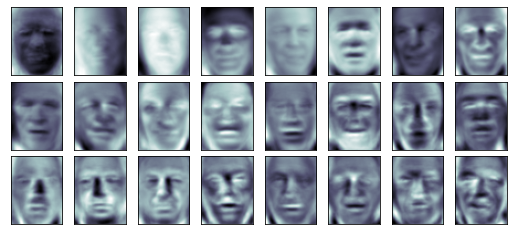

In [76]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

# PLotando Rateio de variancia explicada por número de componentes

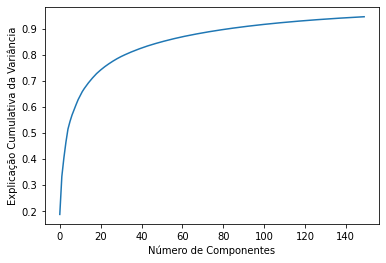

In [77]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Explicação Cumulativa da Variância');

# reconstruindo imagens a partir de um número reduzido de características para o formato original

In [78]:
pca = RandomizedPCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)
print(projected.shape)

(1348, 2914)


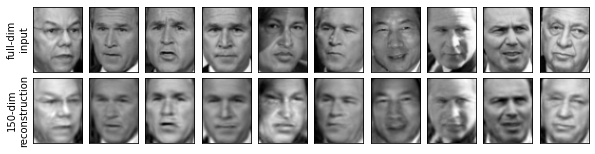

In [79]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

# Comparando classificação com e sem PCA


# Classificador com dados originais

In [ ]:
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

# Transformando com PCA

In [ ]:
pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

# mesma classificação com PCA

In [ ]:
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

## Primeiro Exemplo AutoEncoder

# Modelo do Encoder
* Input shape 784 - apropriado ao mnist

In [107]:
latent_dim = 10 #dimensão do espaço latente

input_shape=784

encoder = Sequential(name="encoder") 
encoder.add(Dense(128, input_shape=(input_shape,), activation="relu")) 
encoder.add(Dense(latent_dim)) # Vetor Latente
encoder.summary() 

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_70 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


# Modelo do Decoder

In [108]:
decoder =  Sequential(name="decoder")
decoder.add(Dense(128, activation="relu", input_shape=(latent_dim,) ))
decoder.add(Dense(input_shape, activation="sigmoid")) 
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_72 (Dense)             (None, 784)               101136    
Total params: 102,544
Trainable params: 102,544
Non-trainable params: 0
_________________________________________________________________


# Auto encoder
* Combina encoder e decoder

In [109]:
input_img = Input(shape=(input_shape,) ) 
z = encoder(input_img) # obtem vetor latente atraves da entrada
recons = decoder(z) # tenta reconstruir a imagem a partir do vetor latente
ae = Model(input_img, recons) # criar o modelo combinando como entrada encoder (input_img) e saída o decoder (recons).
ae.summary() 

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
encoder (Sequential)         (None, 10)                101770    
_________________________________________________________________
decoder (Sequential)         (None, 784)               102544    
Total params: 204,314
Trainable params: 204,314
Non-trainable params: 0
_________________________________________________________________


In [110]:
ae.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=["categorical_crossentropy"])

(60000, 28, 28) (10000, 28, 28)


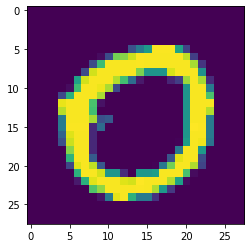

In [111]:
# CArrega dataset
(x_train,y_train), (x_test,y_test) = mnist.load_data()

# Imprime uma imagem qualquer
print(x_train.shape, x_test.shape)
image = x_train[1040] 
plt.imshow(image) 
plt.show()

# Pre-processamento

In [112]:
x_train = (x_train/255.0).astype(np.float32) # normalizacao
x_test = (x_test/255.0).astype(np.float32)

x_train = np.reshape(x_train, (-1, input_shape)) # reshape [60000, 28,28] => [60000, 784]
x_test = np.reshape(x_test, (-1, input_shape)) # Reshape [10000, 28,28] => [10000, 784]

# treino da rede
* Como queremos dar uma entrada para a rede gerar a entrada novamente, passamos como X e Y os mesmo valores

In [113]:
batch_size = 128
epochs = 10
ae.fit(x_train, x_train, batch_size=batch_size, epochs = epochs, validation_data=(x_test,x_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 63us/sample - loss: 554.7673 - categorical_crossentropy: 554.7675 - val_loss: 546.1403 - val_categorical_crossentropy: 546.1403
Epoch 2/10
60000/60000 [==============================] - 3s 53us/sample - loss: 535.5237 - categorical_crossentropy: 535.5236 - val_loss: 540.8557 - val_categorical_crossentropy: 540.8555
Epoch 3/10
60000/60000 [==============================] - 3s 54us/sample - loss: 532.1091 - categorical_crossentropy: 532.1093 - val_loss: 538.8277 - val_categorical_crossentropy: 538.8278
Epoch 4/10
60000/60000 [==============================] - 3s 53us/sample - loss: 530.2557 - categorical_crossentropy: 530.2556 - val_loss: 537.2423 - val_categorical_crossentropy: 537.2422
Epoch 5/10
60000/60000 [==============================] - 3s 53us/sample - loss: 528.9730 - categorical_crossentropy: 528.9731 - val_loss: 536.1665 - val_categorical_crossentropy: 536.1666
Epoch

Image Original


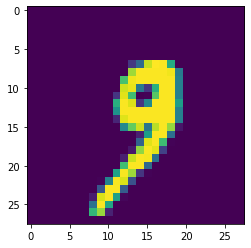

Reconstruída


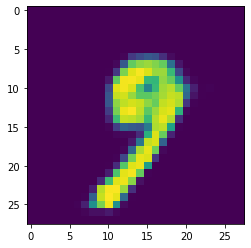

In [106]:
img = x_test[1000] 
imgb = np.reshape(img, (1, input_shape)) 
recons_img = ae.predict( imgb ) #predicao 


recons_img = np.reshape(recons_img, (28,28)) # reshape predicao para (28, 28)

print("Image Original")

img_original = np.reshape(img, (28,28)) # reshape from flatten to squared image.

plt.imshow(img_original)
plt.show()
print("Reconstruída")
plt.imshow(recons_img)
plt.show()

In [ ]:
# Exercícios
* reduza a dimensionalidade da base mnist com PCA, qual é um bom parametro de redução?
* Teste com diferentes parametros de otimizador adam e loss crossentropy obtem alguma diferença no resultado?
* Aumente a quantidade de camadas no encoder e decoder obtem alguma diferença no resultado?
* Faça o teste de Autoencoder com o dataset Fashion Mnist
* Faça o teste de Autoencoder com o dataset de reconhecimento facial, nessa mesma topologia, como fica o resultado?